# Double descent

In [1]:
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

sys.path.insert(0, "../src/")
from double_decent_utils import create_data

from pnml_min_norm_utils import AnalyticalMinNormPNML
from post_simulation_utils import calc_theta_mn

In [2]:
# Plot params
mpl.style.use("seaborn-dark")
mpl.rcParams['axes.grid'] = True
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['figure.dpi'] = 85
mpl.rcParams['axes.labelsize'] = 'large'


# Create data

In [3]:
effective_subspace, feature_size = 500, 1000
trainset_size, testset_size = 400, 1000
noise_var = 1e-1
is_debug = False
x_train, y_train, x_test, y_test = create_data(feature_size, effective_subspace,
                                               trainset_size, testset_size,
                                               noise_var, is_debug)
print('Trainset: ', x_train.shape, y_train.shape)
print('Testset: ', x_test.shape, y_test.shape)


Trainset:  (400, 1000) (400, 1)
Testset:  (1000, 1000) (1000, 1)


# MSE

In [5]:
# feature size list
d_list = np.arange(1, x_train.shape[1], 10)

mse_train_list, mse_test_list = [], []
for d in tqdm(d_list):
    x_train_d = x_train[:, :d]
    x_test_d = x_test[:, :d]

    theta = calc_theta_mn(x_train_d, y_train)

    mse_train = (y_train - x_train_d @ theta) ** 2
    mse_test = (y_test - x_test_d @ theta) ** 2

    mse_train_list.append(np.mean(mse_train))
    mse_test_list.append(np.mean(mse_test))


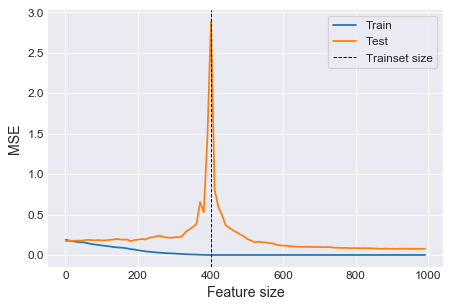

In [16]:
plt.plot(d_list, mse_train_list, label='Train')
plt.plot(d_list, mse_test_list, label='Test')
plt.xlabel('Feature size')
plt.ylabel('MSE')
# plt.yscale('log')
plt.axvline(x=trainset_size, linestyle='--', linewidth=0.8, color='black', label='Trainset size')
plt.legend()
plt.show()


# pNML

In [7]:
regret_list = []
for d in tqdm(d_list):
    x_train_d = x_train[:, :d]
    x_test_d = x_test[:, :d]
    theta = calc_theta_mn(x_train_d, y_train)
    pnml_h = AnalyticalMinNormPNML(x_train_d.T, theta)

    n, m = x_train_d.shape
    if n > m:
        # under parameterized region
        norm_factors = [pnml_h.calc_under_param_norm_factor(phi_test) for phi_test in x_test_d]
    else:
        # over parameterized region
        norm_factors = [pnml_h.calc_over_param_norm_factor(phi_test, noise_var) for phi_test in x_test_d]
    regrets = np.log(norm_factors)
    regret_list.append(regrets.mean())


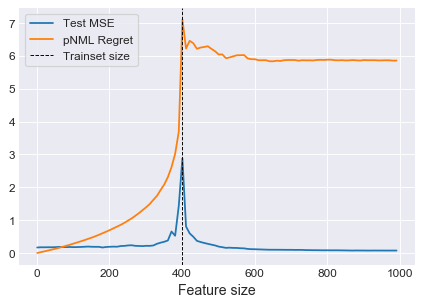

In [14]:
plt.plot(d_list, mse_test_list, label='Test MSE')
plt.plot(d_list, regret_list, label='pNML Regret')
plt.xlabel('Feature size')
# plt.yscale('log')
# plt.xscale('symlog')
plt.axvline(x=trainset_size, linestyle='--', linewidth=0.8, color='black', label='Trainset size')
plt.legend()
plt.show()


## Diffrent noise

In [9]:
noise_vars = [1e6, 1e3, 1, 1e-1, 1e-3, 1e-6]

noise_vars_results = []
for noise in noise_vars:
    regret_list = []
    for d in tqdm(d_list):
        x_train_d = x_train[:, :d]
        x_test_d = x_test[:, :d]
        theta = calc_theta_mn(x_train_d, y_train)
        pnml_h = AnalyticalMinNormPNML(x_train_d.T, theta)

        n, m = x_train_d.shape
        if n > m:
            # under parameterized region
            norm_factors = [pnml_h.calc_under_param_norm_factor(phi_test) for phi_test in x_test_d]
        else:
            # over parameterized region
            norm_factors = [pnml_h.calc_over_param_norm_factor(phi_test, noise) for phi_test in x_test_d]
        regrets = np.log(norm_factors)
        regret_list.append(regrets.mean())
    noise_vars_results.append(regret_list)


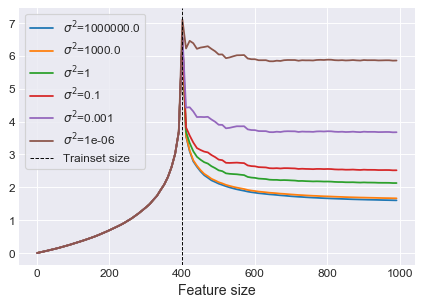

In [15]:
for regret_list, noise in zip(noise_vars_results, noise_vars):
    plt.plot(d_list, regret_list, label=r'$\sigma^2$={}'.format(noise))
plt.xlabel('Feature size')
# plt.yscale('log')
plt.axvline(x=trainset_size, linestyle='--', linewidth=0.8, color='black', label='Trainset size')
plt.legend()
plt.show()
